In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import unitary_group
from tqdm import tqdm
import random
import time

In [19]:
np.random.seed(seed=233423)

n_qubits = 3

plt.rcParams["figure.figsize"] = (6,6)

# Step_1 generation Kraus matrix

In [20]:
def generate_kraus_matrix(n_qubits, rank_of_transition, alpha):
    start_time = time.time()
    size = 2**n_qubits
    
    M_matrices = []
    V = unitary_group.rvs(size * rank_of_transition)
    for i in range(rank_of_transition):
        M_matrices.append(V[i * size: (i+1) * size, 0: size])
    
    rand_unit_matr = unitary_group.rvs(size)
    tensor_dot_matr_U = np.kron(rand_unit_matr, np.conjugate(rand_unit_matr))
    tensor_dot_matr_sum = np.kron(M_matrices[0], np.conjugate(M_matrices[0]))
    for j in range(1, rank_of_transition):
        tensor_dot_matr_sum += np.kron(M_matrices[j], np.conjugate(M_matrices[j]))    

    trans_matr = (1 - alpha) * tensor_dot_matr_U + alpha * tensor_dot_matr_sum
    print("generating time: --- %s seconds ---" % (time.time() - start_time))
    return trans_matr
    

rank_of_transition = 3
alpha = 0.6
transition_matrix = generate_kraus_matrix(n_qubits, rank_of_transition, alpha)

generating time: --- 0.0030002593994140625 seconds ---


# Step_2 Check Kraus Matrix

In [21]:
def calculate_eigen_values_of_Kraus(transition_matrix):
    start_time = time.time()
    x = np.array([])
    y = np.array([])
    r = np.array([])
    eigs = np.linalg.eig(transition_matrix)[0]
    x = np.concatenate((x,np.real(eigs)))
    y = np.concatenate((y,np.imag(eigs)))
    r = np.concatenate((r,np.abs(eigs)))
    print("eigen values calculating time: --- %s seconds ---" % (time.time() - start_time))
    return x, y, r

x, y, r = calculate_eigen_values_of_Kraus(transition_matrix)

eigen values calculating time: --- 0.026001453399658203 seconds ---


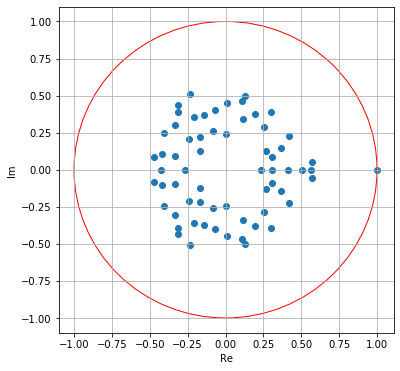

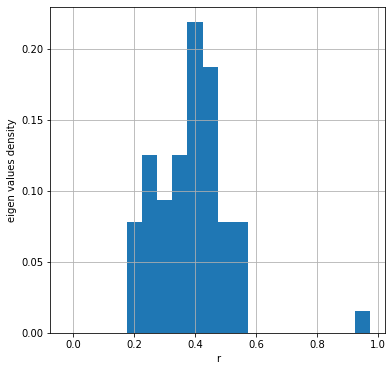

In [22]:
def draw_eigen_values_of_Kraus(x, y, r):
    circle = plt.Circle((0, 0), 1.0, color='r', fill = False)
    plt.gca().add_patch(circle)
    if len(transition_matrix) >= 5000:
        plt.scatter(x,y, alpha = 0.01)
    elif len(transition_matrix) >= 500:
        plt.scatter(x,y, alpha = 0.1)
    else:
        plt.scatter(x,y, alpha = 1.0)
    plt.xlabel('Re')
    plt.ylabel('Im')
    plt.grid(True)
    plt.show()
    # eigen values density from r
    num_of_intervals = 20
    density = []
    intervals_values = np.arange(0.005, 1.055, 0.05)
    for i in range(num_of_intervals):
        amount = len(r[(intervals_values[i] < r) & (r < intervals_values[i+1])])
        density.append(amount/(len(transition_matrix)))
    x = np.arange(0.0, 1.0, 0.05)
    assert 0.999 < np.sum(density) < 1.001, f"sum = {np.sum(density)} sum must be 1.000"
    plt.bar(x, density, 0.05)
    plt.grid(True)
    plt.xlabel('r')
    plt.ylabel('eigen values density')
    plt.show()
        
draw_eigen_values_of_Kraus(x, y, r)

# Step_3 generating initial states as Pauli chains

In [23]:
"0,1,2,3,4,5"
"0,1,+,-,i,-i"

class InitStateGenerator:
    def __init__(self, n_qubits):
        self.n_qubits = n_qubits
        self.rotate_one_qubit_x = np.array([[0.0, 1.0], 
                                            [1.0, 0.0]])
        self.rotate_one_qubit_y = np.array([[0.0, -1.0j], 
                                            [1.0j, 0.0]])
        self.rotate_one_qubit_z = np.array([[1.0, 0.0], 
                                            [0.0, -1.0]])
        self.identity_matrix = np.array([[1.0, 0.0], 
                                         [0.0, 1.0]])
        self.hadamar_matrix = np.array([[1.0, 1.0], 
                                        [1.0, -1.0]])/np.sqrt(2)
        self.phase_matrix = np.array([[1.0, 0.0], 
                                      [0.0, 1.0j]])
        self.num_of_basis_states = 6
        self.combinations = []
        

    def rotator(self, dense_matrix, qubit_number, state_rotate_to):
        if state_rotate_to == 1:
            rotate_matrix = self.rotate_one_qubit_x
        if state_rotate_to == 2:
            rotate_matrix = self.hadamar_matrix
        if state_rotate_to == 3:
            rotate_matrix = self.hadamar_matrix @ self.rotate_one_qubit_x
        if state_rotate_to == 4:
            rotate_matrix = self.phase_matrix @ self.hadamar_matrix
        if state_rotate_to == 5:
            rotate_matrix = self.phase_matrix @ self.hadamar_matrix @ self.rotate_one_qubit_x
        
        transform_matrix = 1
        for i in range(self.n_qubits):
            if i==qubit_number:
                transform_matrix = np.kron(rotate_matrix, transform_matrix)
            else:
                transform_matrix = np.kron(self.identity_matrix, transform_matrix)
        new_dense_matrix = transform_matrix @ dense_matrix @ np.conjugate(transform_matrix.T)
        return new_dense_matrix
    
    def generate_combination(self, num):
        a = [num%self.num_of_basis_states]
        while num//self.num_of_basis_states>0:
            num = num // self.num_of_basis_states
            a.append(num%self.num_of_basis_states)
        
        while len(a) < self.n_qubits:
            a.append(0)
    
        return a
    
    def generate_state(self, combination:list):
        n_qubits = len(combination)
        dense_matrix = np.zeros((2**n_qubits, 2**n_qubits))
        dense_matrix[0][0] = 1.0
        for i in range(n_qubits):
            if combination[i] > 0:
                dense_matrix = self.rotator(dense_matrix, i, combination[i])
            
        return dense_matrix
    
    def generate(self, num_of_states):
        dense_matrices = []
        for i in tqdm(range(num_of_states)):
            combination = self.generate_combination(i)
            self.combinations.append(combination)
            dense_matrices.append(self.generate_state(combination))
        return self.combinations, dense_matrices


num_of_basis_states = 6
init_states_generator = InitStateGenerator(n_qubits)

start_time = time.time()
init_combinations, init_dense_matrices = init_states_generator.generate(num_of_basis_states**n_qubits)
print("init dense_matrices generating time: --- %s seconds ---" % (time.time() - start_time))

100%|██████████████████████████████████████| 216/216 [00:00<00:00, 1393.47it/s]


init dense_matrices generating time: --- 0.16200923919677734 seconds ---


In [24]:
for i in range(len(init_dense_matrices)):
    if 0.9999 < np.abs(np.sum(np.diag(init_dense_matrices[i]))) < 1.0001:
        pass
    else:
        print(f"Warning! trace of {i} dense matrix is {np.abs(np.sum(np.diag(dense_matrices[i])))}")
    if np.max((np.conjugate(init_dense_matrices[i]) - init_dense_matrices[i].T)) < 0.0001:
        pass
    else:
        print(f"Warning! max of (dense matrix - dense matrix_dagger) for index {i} \
              is {np.abs(np.sum(np.diag(init_dense_matrices[i])))}")

# Step_4 applying transition matrix

In [25]:
dense_matrices = []
for i in range(len(init_dense_matrices)):
    dense_matrices.append((transition_matrix @ init_dense_matrices[i].reshape(4**n_qubits)).
                             reshape((2**n_qubits, 2**n_qubits)))

In [26]:
for i in range(len(dense_matrices)):
    if 0.9999 < np.abs(np.sum(np.diag(dense_matrices[i]))) < 1.0001:
        pass
    else:
        print(f"Warning! trace of {i} dense matrix is {np.abs(np.sum(np.diag(dense_matrices[i])))}")
    if np.max((np.conjugate(dense_matrices[i]) - dense_matrices[i].T)) < 0.0001:
        pass
    else:
        print(f"Warning! max of (dense matrix - dense matrix_dagger) for index {i} \
              is {np.abs(np.sum(np.diag(dense_matrices[i])))}")

# Step_5 sampling exit data

In [29]:
class InitMeasuresStatesGenerator:
    def __init__(self, n_qubits, num_of_basis_init_states):
        self.n_qubits = n_qubits
        self.num_of_basis_init_states = num_of_basis_init_states
        self.num_of_basis_measure_states = 3
        self.hadamar_matrix = np.array([[1.0, 1.0], 
                                        [1.0, -1.0]])/np.sqrt(2)
        self.phase_matrix = np.array([[1.0, 0.0], 
                                      [0.0, 1.0j]])
        self.identity_matrix = np.array([[1.0, 0.0], 
                                         [0.0, 1.0]])
        self.rotate_one_qubit_x = np.array([[0.0, 1.0], 
                                            [1.0, 0.0]])
        self.t_matrix = np.array([[1.0, 0.0], 
                                  [0.0, np.exp(0.25j*np.pi)]])
        
        self.init_combinations = []
        self.measure_combinations = []
    
    @staticmethod
    def check_dense_matrix_properties(dense_matrix):
        if 0.9999 < np.abs(np.sum(np.diag(dense_matrix))) < 1.0001:
            pass
        else:
            print(f"Warning! trace of dense matrix is {np.abs(np.sum(np.diag(dense_matrix)))}")
        if np.max((np.conjugate(dense_matrix) - dense_matrix.T)) < 0.0001:
            pass
        else:
            print(f"Warning! max of (dense matrix - dense matrix_dagger) \
                  is {np.abs(np.sum(np.diag(dense_matrix)))}")
        eigs = np.linalg.eig(dense_matrix)[0]
        if np.all(np.real(eigs) > -0.0001):
            pass
        else:
            print(f'Warning! eigen values for are {np.real(eigs)} but it should all be >= 0')
    
    def rotator(self, dense_matrix, qubit_number: int, state_rotate_to: int, mode: str):  # z y x
        if mode == 'measure':
            if state_rotate_to == 1:
                rotate_matrix = self.hadamar_matrix @ np.conjugate(self.phase_matrix).T
            if state_rotate_to == 2:
                rotate_matrix = self.hadamar_matrix
        elif mode == 'init':
            if state_rotate_to == 1:
                rotate_matrix = self.rotate_one_qubit_x
            if state_rotate_to == 2:
                rotate_matrix = self.hadamar_matrix
            if state_rotate_to == 3:
                rotate_matrix = self.hadamar_matrix @ self.rotate_one_qubit_x
            if state_rotate_to == 4:
                rotate_matrix = self.phase_matrix @ self.hadamar_matrix
            if state_rotate_to == 5:
                rotate_matrix = self.phase_matrix @ self.hadamar_matrix @ self.rotate_one_qubit_x
            if state_rotate_to == 6:
                rotate_matrix = self.t_matrix @ self.hadamar_matrix
        else:
            raise ValueError('Wrong mode!')
        
        transform_matrix = 1.0
        for i in range(self.n_qubits):
            if i==qubit_number:
                transform_matrix = np.kron(rotate_matrix, transform_matrix)
            else:
                transform_matrix = np.kron(self.identity_matrix, transform_matrix)
        new_dense_matrix = transform_matrix @ dense_matrix @ np.conjugate(transform_matrix.T)
        return new_dense_matrix
    
    def generate_combination(self, num, mode):
        if mode == 'init':
            max_num = self.num_of_basis_init_states
        elif mode == 'measure':
            max_num = self.num_of_basis_measure_states
        else:
            raise ValueError('unknown type of mode')
        
        combination = [num%max_num]
        while num//max_num > 0:
            num = num // max_num
            combination.append(num%max_num)
        
        while len(combination) < self.n_qubits:
            combination.append(0)
    
        return combination
    
    def generate_state(self, combination:list, dense_matrix, mode):
        n_qubits = len(combination)
        for i in range(n_qubits):
            if combination[i] > 0:
                dense_matrix = self.rotator(dense_matrix, i, combination[i], mode)
            
        return dense_matrix
    
    def generate(self, num_of_states):
        dense_matrices = []
        mode = 'init'
        zero_vec = np.zeros(2**self.n_qubits)
        zero_vec[0] = 1.0
        zero_dense_matrix = np.diag(zero_vec)
        for i in range(num_of_states):
            combination = self.generate_combination(i, 'init')
            self.init_combinations.append(combination)
            dense_matrix = self.generate_state(combination, zero_dense_matrix, mode)
            self.check_dense_matrix_properties(dense_matrix)
            dense_matrices.append(dense_matrix)
        return self.init_combinations, dense_matrices
    
    def get_distribution(self, dense_matrix, num_of_sample_for_one_scheme):
        probs = np.real(np.diag(dense_matrix)).copy()
        probs_copy = probs.copy()
        probs[-1] = 1.0 - np.sum(probs_copy[:-1])
        states = np.array([i for i in range(2**self.n_qubits)])
        measures = np.random.choice(states, num_of_sample_for_one_scheme, p = probs)
        distribution = np.zeros(2**self.n_qubits)
        for element in measures:
            distribution[element] += 1.0
        return distribution / num_of_sample_for_one_scheme
    
    def get_distributions(self, dense_matrices: list, num_of_sample_for_one_scheme: int):
        mode = 'measure'
        distributions = []
        for i in tqdm(range(len(dense_matrices))):
            self.check_dense_matrix_properties(dense_matrices[i])
            
            for j in range(self.num_of_basis_measure_states**self.n_qubits):
                combination = self.generate_combination(j, mode)
                if len(self.measure_combinations) < self.num_of_basis_measure_states**self.n_qubits:
                    self.measure_combinations.append(combination)  
                basis_dense_matrix = self.generate_state(combination, dense_matrices[i], mode)
                self.check_dense_matrix_properties(basis_dense_matrix)
                distribution = self.get_distribution(basis_dense_matrix, num_of_sample_for_one_scheme)
                distributions.append(distribution)
        return self.measure_combinations, distributions

num_of_basis_init_states = 6
num_of_sample_for_one_scheme = 2000
init_measure_states_generator = InitMeasuresStatesGenerator(n_qubits, num_of_basis_init_states)
start_time = time.time()
measure_combinations, distributions = init_measure_states_generator.get_distributions(dense_matrices,
                                                                                    num_of_sample_for_one_scheme)
print("distrubutions of measures generating time: --- %s seconds ---" % (time.time() - start_time))

100%|████████████████████████████████████████| 216/216 [00:11<00:00, 20.30it/s]


distrubutions of measures generating time: --- 11.386651515960693 seconds ---


In [30]:
if len(distributions) == 18**n_qubits: # 6**n_qubits * 3**n_qubits
    pass
else:
    print(f"Warning! len of distributions is {len(distributions)}, but it should be {18**n_qubits}")

example of probabilities distribution: [0.033  0.1705 0.025  0.263  0.123  0.1585 0.1295 0.0975]


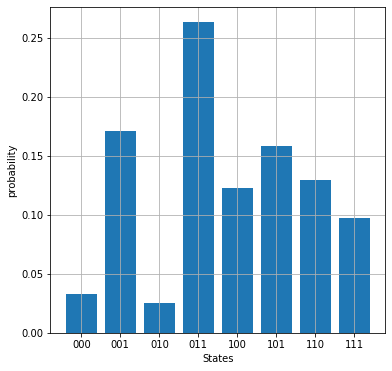

In [32]:
def to_binary(number, n_qubits):
    binary_str = ''
    while(True):
        if number == 0:
            break
        elif number % 2 == 0:
            number = number // 2
            binary_str = '0' + binary_str
        else:
            number = number // 2
            binary_str = '1' + binary_str  
    while(len(binary_str) < n_qubits):
        binary_str = '0' + binary_str
    return binary_str

dist = distributions[1]  # second example
print(f'example of probabilities distribution: {distributions[1]}')
list_of_states = [to_binary(i, n_qubits) for i in range(2**n_qubits)]
plt.bar(list_of_states, dist)
plt.grid(True)
plt.xlabel('States')
plt.ylabel('probability')
plt.show()